<a href="https://colab.research.google.com/github/a151815058/Buy-Til-You-Die-Predict-Customer-Lifetime-Value-jourdeness/blob/main/CLV_plusEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Package

In [ ]:
pip install Lifetimes

     |████████████████████████████████| 584 kB 5.2 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error

from lifetimes import BetaGeoFitter, GammaGammaFitter, ModifiedBetaGeoFitter
from lifetimes.utils import \
    calibration_and_holdout_data, \
    summary_data_from_transaction_data, \
    calculate_alive_path
from lifetimes.plotting import \
    plot_frequency_recency_matrix, \
    plot_probability_alive_matrix, \
    plot_period_transactions, \
    plot_history_alive, \
    plot_cumulative_transactions, \
    plot_calibration_purchases_vs_holdout_purchases, \
    plot_transaction_rate_heterogeneity, \
    plot_dropout_rate_heterogeneity


import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set(rc={'image.cmap': 'coolwarm'})

pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.0f}'.format

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# EDA

In [ ]:
dataset_path = '/content/drive/MyDrive/T大使/dataset/'
data = pd.read_csv(dataset_path+'sales_data.csv')
print(f'date: {data.sale_date.min()} ~ {data.sale_date.max()}')
# date: 2018-11-01 ~ 2021-06-30

date: 2018-11-01 ~ 2021-06-30


In [ ]:
# 學姊的
# drop some category: '系統用','贈品','市場開發','店用商品'
data = data.drop(data.loc[data['categorydescription'].isin(['系統用','贈品','市場開發','店用商品'])].index)
data.categorydescription.value_counts() # check

產品正貨     1067699
身體副課程     266336
臉部主課程     195466
身體主課程     180313
醫美療程       29304
臉部副課程      18202
產品沙貨        2135
加強課程        1845
Name: categorydescription, dtype: int64

In [ ]:
data.rename(columns={'sales_no':'InvoiceNo'},inplace=True)
data.rename(columns={'stock_id':'StockCode'},inplace=True)
data.rename(columns={'stock_description':'Description'},inplace=True)
data.rename(columns={'sales_qty':'Quantity'},inplace=True)
data.rename(columns={'sale_date':'InvoiceDate'},inplace=True)
data.rename(columns={'unit_price':'UnitPrice'},inplace=True)
data.rename(columns={'member_code':'CustomerID'},inplace=True)
data.rename(columns={'name':'Country'},inplace=True)
data.rename(columns={'member_code':'CustomerID'},inplace=True)
data.rename(columns={'member_start_date':'member_start_date'},inplace=True)
data.rename(columns={'first_trans_date':'first_trans_date'},inplace=True)

data.columns

Index(['InvoiceNo', 'categorydescription', 'categorydescription1', 'StockCode',
       'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID',
       'Country', 'member_start_date', 'first_trans_date'],
      dtype='object')

In [ ]:
data.isna().any()

InvoiceNo               False
categorydescription     False
categorydescription1    False
StockCode               False
Description             False
Quantity                False
InvoiceDate             False
UnitPrice               False
CustomerID               True
Country                 False
member_start_date        True
first_trans_date         True
dtype: bool

In [ ]:
print(f'Before drop null row: {len(data)} rows')
data.drop(data[data['CustomerID'].isnull()].index,inplace=True)
print(f'After drop null row: {len(data)} rows')

Before drop null row: 1761300 rows
After drop null row: 1760793 rows


In [ ]:
# are any missing values left?
booMiss = data.isnull().values.any()
if booMiss:
    _ = [print(k,":",v) for k,v in data.isnull().sum().items() if v!=0]   # number missing

member_start_date : 49378
first_trans_date : 4228


In [ ]:
# restrict to transactions with positive quantities
data = data[data["Quantity"] > 0]

# datetime to date format
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"]).dt.date #normalize()
#data.set_index("InvoiceDate", inplace=False)

# treat CustomerID as a categorical variable
data["CustomerID"] = data["CustomerID"].astype(np.int64).astype(object)

# review the categorical variables
data.describe(include='object').T

count  unique            top     freq
InvoiceNo             1752450  771267   PS5360021832      502
categorydescription   1752450       8           產品正貨  1059805
categorydescription1  1752450      24            不分版   671248
StockCode             1752450     916        HB90A01    64577
Description           1752450     867  全背順氣活力SPA課程單堂    64577
InvoiceDate           1752450     957     2021-03-03    25405
CustomerID            1752450   89251  9100000624389     3872
Country               1752450       9             中區   351317
member_start_date     1703220    7598     2003-09-23     4706
first_trans_date      1748227    3318     2012-10-06    17115

In [ ]:
# delete columns that are not useful
data.drop(["InvoiceNo", "StockCode", "Description", "Country","member_start_date","first_trans_date","categorydescription","categorydescription1"], axis=1, inplace=True)

data.describe(include='object').T

count unique            top   freq
InvoiceDate  1752450    957     2021-03-03  25405
CustomerID   1752450  89251  9100000624389   3872

In [ ]:
data['Revenue'] = data['UnitPrice']*data['Quantity']
data.head()

Quantity InvoiceDate  UnitPrice     CustomerID  Revenue
1         1  2018-11-01        282  9100002151296      282
2         1  2018-11-01      1,017  9100002151296    1,017
3         1  2018-11-01      2,212  9100002151296    2,212
4         1  2018-11-01      1,106  9100002151296    1,106
5         1  2018-11-01      1,382  9100002151296    1,382

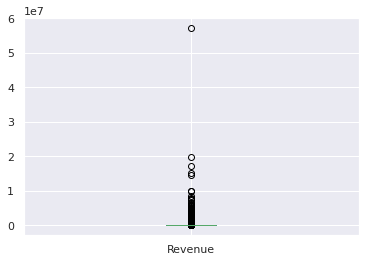

In [ ]:
data['Revenue'].plot.box()

In [ ]:
#def寫python的函式
def Outlier_treatment(datacolumn): #傳入datacolumn這個變數
  Q1,Q3 =np.percentile(datacolumn,[25,75]) #算出Q1=25 Q3=75 這個是固定的
  IQR = Q3-Q1
  lower_range = Q1 - (1.5*IQR)
  high_range = Q3 + (1.5*IQR)
  return lower_range,high_range

In [ ]:
#抓出異常值
lowerbound,highbound = Outlier_treatment(data['Revenue'])

data[(data['Revenue']< lowerbound) | (data['Revenue']>highbound)]

Quantity InvoiceDate  UnitPrice     CustomerID  Revenue
6              24  2018-11-01      4,800  9100002151296  115,200
9               5  2018-11-01      2,500  9100001182833   12,500
62              4  2018-11-01      3,360  9100001433126   13,440
76              4  2018-11-01      3,200  9100001178805   12,800
95             12  2018-11-01     18,300  9100000307244  219,600
...           ...         ...        ...            ...      ...
2182439         1  2021-06-30      7,999  9100001025758    7,999
2182441         1  2021-06-30      7,999  9100001025758    7,999
2182476         8  2021-06-30      1,048  9100000106229    8,384
2182482         5  2021-06-30      4,000  9100000437309   20,000
2182485         3  2021-06-30      3,120  9100000437309    9,360

[289257 rows x 5 columns]

In [ ]:
data.drop(data[data['Revenue']> highbound].index,inplace=True) #去除異常值

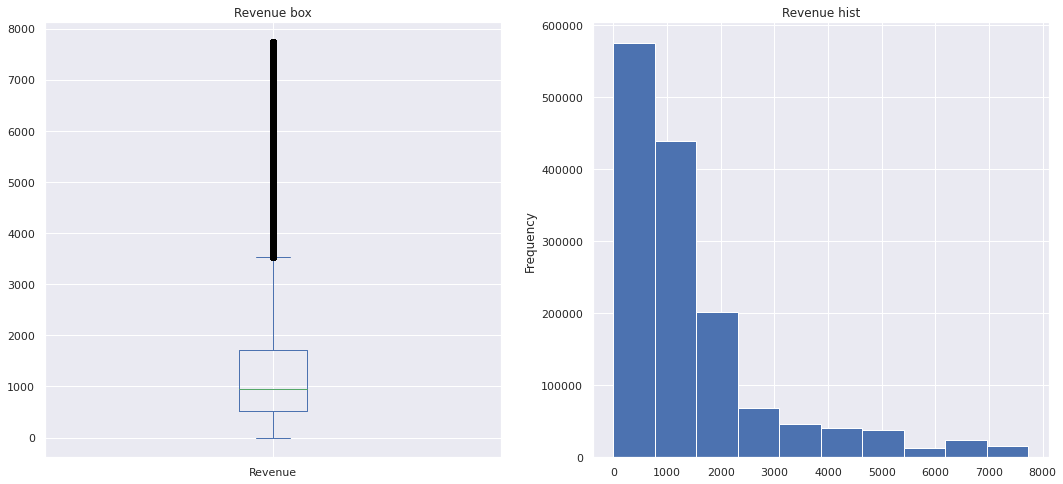

In [ ]:
figure, axis = plt.subplots(1, 2,figsize=(18,8))
data['Revenue'].plot.box(ax=axis[0])
axis[0].set_title('Revenue box')
data['Revenue'].plot.hist(ax=axis[1])
axis[1].set_title('Revenue hist')
plt.show()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1463193 entries, 1 to 2182493
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Quantity     1463193 non-null  float64
 1   InvoiceDate  1463193 non-null  object 
 2   UnitPrice    1463193 non-null  float64
 3   CustomerID   1463193 non-null  object 
 4   Revenue      1463193 non-null  float64
dtypes: float64(3), object(2)
memory usage: 67.0+ MB


In [ ]:
df0 = data.copy()

In [ ]:
data.to_csv(dataset_path+'data_wrangling.csv',index=False)

# 2. BG/NBD Model

## 2.0 Load Data

In [ ]:
dataset_path = '/content/drive/MyDrive/T大使/dataset/'
df1 = pd.read_csv(dataset_path+'data_wrangling.csv')
df1["InvoiceDate"] = pd.to_datetime(df1["InvoiceDate"]).dt.date

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1463193 entries, 0 to 1463192
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Quantity     1463193 non-null  float64
 1   InvoiceDate  1463193 non-null  object 
 2   UnitPrice    1463193 non-null  float64
 3   CustomerID   1463193 non-null  int64  
 4   Revenue      1463193 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 55.8+ MB


## 2.1 Train/Test Split

In [ ]:
# train/test split (calibration/holdout)
t_holdout = 240                                         # days to reserve for holdout period

max_date = df1["InvoiceDate"].max()                     # end date of observations
# print("end of observations:", max_date)

max_cal_date = max_date - timedelta(days=t_holdout)     # end date of chosen calibration period
# print("end of calibration period:", max_cal_date)
# calibration:可以想成是training data
# holdout:可以想成是testing data
print(f'Training period: {df1["InvoiceDate"].min()} ~ {max_cal_date}')
print(f'Testing period: {max_cal_date+timedelta(days=1)} ~ {max_date}')

df_ch = calibration_and_holdout_data(
        transactions = df1, 
        customer_id_col = "CustomerID", 
        datetime_col = "InvoiceDate",
        monetary_value_col = "Revenue", 
        calibration_period_end = max_cal_date, 
        observation_period_end = max_date, 
        freq = "D")  


Training period: 2018-11-01 ~ 2020-11-02
Testing period: 2020-11-03 ~ 2021-06-30


In [ ]:
pd.options.display.float_format = '{:,.0f}'.format
df_ch.describe()

frequency_cal  recency_cal  ...  monetary_value_holdout  duration_holdout
count         77,724       77,724  ...                  77,724            77,724
mean               4          224  ...                     534               240
std                8          259  ...                     919                 0
min                0            0  ...                       0               240
25%                0            0  ...                       0               240
50%                1           69  ...                       0               240
75%                6          471  ...                     932               240
max              133          732  ...                   7,664               240

[8 rows x 7 columns]

In [ ]:
# training: frequency
pd.options.display.float_format = '{:,.3f}'.format
x = df_ch["frequency_cal"].value_counts(normalize=True)
x = x.nlargest(15)
print("frequency:")
x.sort_index(ascending=True)

frequency:


0.000    0.421
1.000    0.112
2.000    0.075
3.000    0.056
4.000    0.045
5.000    0.039
6.000    0.032
7.000    0.026
8.000    0.022
9.000    0.020
10.000   0.017
11.000   0.014
12.000   0.013
13.000   0.011
14.000   0.010
Name: frequency_cal, dtype: float64

In [ ]:
# training: axis length
max_freq = df_ch["frequency_cal"].quantile(0.98)
max_rec = df_ch["recency_cal"].max()
max_T = df_ch["T_cal"].max()

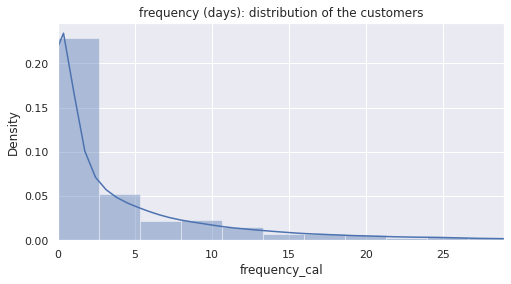

In [ ]:
# training
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(df_ch["frequency_cal"])
ax.set_xlim(0, max_freq)
ax.set_title("frequency (days): distribution of the customers");

Text(0.5, 1.0, 'recency (days): distribution of the customers')

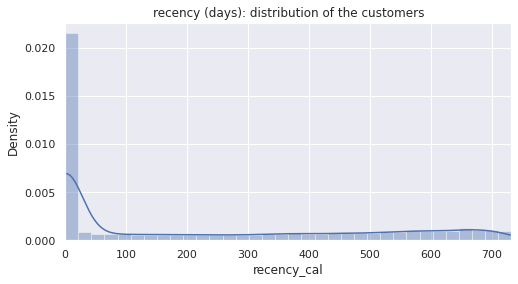

In [ ]:
# training
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(df_ch["recency_cal"])
ax.set_xlim(0, max_rec)
ax.set_title("recency (days): distribution of the customers")

Text(0.5, 1.0, 'customer age T (days): distribution of the customers')

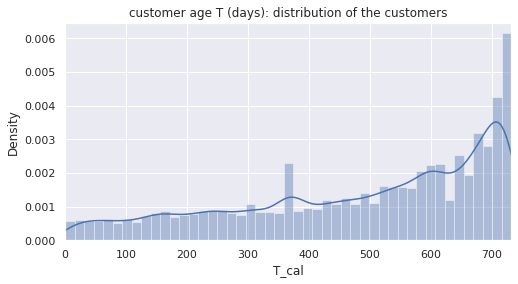

In [ ]:
# training
fig = plt.figure(figsize=(8, 4)) 
ax = sns.distplot(df_ch["T_cal"])
ax.set_xlim(0, max_T)
ax.set_title("customer age T (days): distribution of the customers")

## 2.2 Fit the BG/NBD Model


In [ ]:
# training: BG/NBD model
bgf = ModifiedBetaGeoFitter(penalizer_coef=1e-11)
bgf.fit(
        frequency = df_ch["frequency_cal"], 
        recency = df_ch["recency_cal"], 
        T = df_ch["T_cal"],  
        weights = None, 
        verbose = True,   
        tol = 0.0001)

Optimization terminated successfully.
         Current function value: -6.317670
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22


<lifetimes.ModifiedBetaGeoFitter: fitted with 77724 subjects, a: 0.14, alpha: 76.18, b: 0.32, r: 1.14>

In [ ]:
# training: summary
pd.options.display.float_format = '{:,.3f}'.format
bgf.summary

coef  se(coef)  lower 95% bound  upper 95% bound
r      1.137     0.016            1.105            1.168
alpha 76.183     0.984           74.255           78.112
a      0.144     0.002            0.139            0.148
b      0.320     0.006            0.307            0.332

<Figure size 864x864 with 0 Axes>

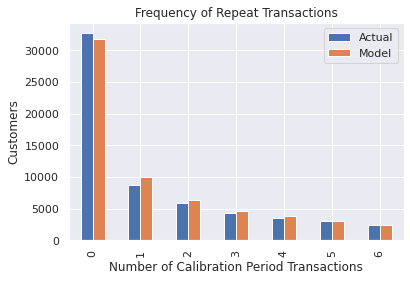

In [ ]:
# training: does the model reflect the actual data closely enough?

# frequency of repeat transactions: predicted vs actual
fig = plt.figure(figsize=(12, 12))
plot_period_transactions(bgf);

<Figure size 504x504 with 0 Axes>

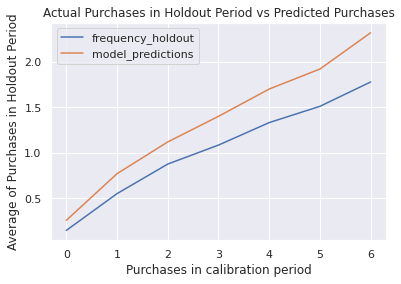

In [ ]:
# testing: predicted vs actual purchases in holdout period
fig = plt.figure(figsize=(7, 7)) 
plot_calibration_purchases_vs_holdout_purchases(bgf, df_ch);

In [ ]:
# print(df_ch.columns)
df_rft = df_ch.copy()
df_rft.rename(columns={'frequency_cal':'frequency', 'recency_cal':'recency',
                       'T_cal':'T','monetary_value_cal':'monetary_value'},inplace=True)

In [ ]:
#axis length
max_freq = int(df_rft["frequency"].max())  #quantile(0.95))          
max_T = int(df_rft["T"].max())                         
max_rec = int(df_rft["recency"].max())  
print(max_freq)

133


## 2.3 Predictions

In [ ]:
# predict purchases for a selected customer for t days
t = 30
custID = 9100000000114

df_rft_C = df_rft.loc[custID,:]
predC = bgf.predict(    t, 
                        df_rft_C["frequency"], 
                        df_rft_C["recency"], 
                        df_rft_C["T"])
print("customer", custID, ": expected number of purchases within", t, "days =", f'{predC:.1f}')

customer 9100000000114 : expected number of purchases within 30 days = 0.3


In [ ]:
# selected customer: transactions
df1C = df1[df1["CustomerID"] == custID]
df1C.describe()

Quantity  UnitPrice            CustomerID   Revenue
count    19.000     19.000                19.000    19.000
mean      1.263  1,430.158 9,100,000,000,114.000 2,067.947
std       0.452    885.069                 0.000 1,986.903
min       1.000    155.000 9,100,000,000,114.000   155.000
25%       1.000    851.000 9,100,000,000,114.000   851.000
50%       1.000  1,100.000 9,100,000,000,114.000 1,100.000
75%       1.500  1,767.500 9,100,000,000,114.000 2,570.000
max       2.000  3,588.000 9,100,000,000,114.000 7,176.000

972


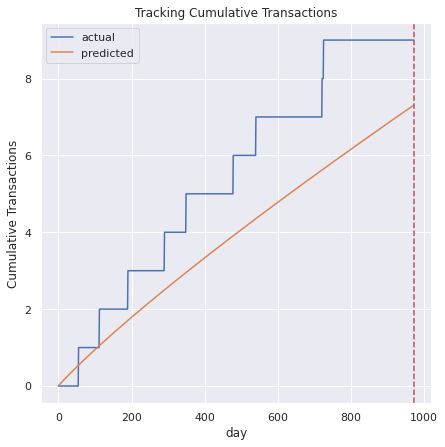

In [ ]:
# X selected customer: cumulative transactions
max_date = df1["InvoiceDate"].max()
min_date = df1["InvoiceDate"].min()
span_days = (max_date - min_date).days
print(span_days)

fig = plt.figure(figsize=(7, 7)) 
plot_cumulative_transactions(
            model = bgf,  
            transactions = df1C, 
            datetime_col = "InvoiceDate",  
            customer_id_col = "CustomerID",  
            t = span_days,  
            t_cal = span_days);

In [ ]:
# helper function: predict each customer's purchases over next t days
def predict_purch(df, t):
        df["predict_purch_" + str(t)] = \
                bgf.predict(
                    t, 
                    df["frequency"], 
                    df["recency"], 
                    df["T"])

In [ ]:
# call helper function: predict each customer's purchases over multiple time periods
t_FC = [10, 30, 60, 90]
_ = [predict_purch(df_rft, t) for t in t_FC]
pd.options.display.float_format = '{:,.1f}'.format
print("predicted number of purchases for each customer over next t days:")
df_rft

predicted number of purchases for each customer over next t days:


frequency  recency  ...  predict_purch_60  predict_purch_90
CustomerID                         ...                                    
9100000000060        6.0    527.0  ...               0.5               0.8
9100000000084        6.0    641.0  ...               0.5               0.8
9100000000091        0.0      0.0  ...               0.0               0.0
9100000000114        7.0    540.0  ...               0.6               0.9
9100000000152        0.0      0.0  ...               0.0               0.0
...                  ...      ...  ...               ...               ...
9100003140534        1.0    399.0  ...               0.1               0.2
9100003149889        1.0     12.0  ...               0.1               0.2
9100003151981        0.0      0.0  ...               0.0               0.1
9100003171279       19.0    662.0  ...               1.5               2.2
9100003206438        0.0      0.0  ...               0.0               0.0

[77724 rows x 12 columns]

In [ ]:
# top 10 customers over next 30 days
print("top 10 customers, by their predicted purchases over next 30 days")
df_rft.sort_values(by="predict_purch_30", ascending=False).head(10)

top 10 customers, by their predicted purchases over next 30 days


frequency  recency  ...  predict_purch_60  predict_purch_90
CustomerID                         ...                                    
9100000024912      133.0    725.0  ...               9.9              14.9
9100000300535      123.0    702.0  ...               9.4              14.1
9100002812555       42.0    222.0  ...               8.3              12.4
9100000063171      111.0    712.0  ...               8.3              12.5
9100001507919      111.0    730.0  ...               8.3              12.4
9100001543061      104.0    727.0  ...               7.8              11.6
9100001654590       99.0    727.0  ...               7.4              11.1
9100000421681       96.0    693.0  ...               7.4              11.0
9100000170299       95.0    728.0  ...               7.1              10.6
9100000069067       94.0    727.0  ...               7.0              10.5

[10 rows x 12 columns]

In [ ]:
# recency, frequency, T
dfx = df1[df1["CustomerID"] == 9100000247519]
xmax_date = dfx["InvoiceDate"].max()
xmin_date = dfx["InvoiceDate"].min()

# recency:
print("customer minimum date:", xmin_date)
print("customer maximum date:", xmax_date)
xrec = (xmax_date - xmin_date).days
print("recency:", xrec)                                    # recency = time span between first and last purchase

# age T:
xmaxall_date = df1["InvoiceDate"].max()
print("population maximum date:", xmaxall_date)
xage = (xmaxall_date - xmin_date).days                    # age T
print("T:", xage)

# frequency:
xfreq = len(dfx[dfx["Quantity"] > 0].groupby("InvoiceDate"))-1    # frequency: periods with repeat purchases
print("frequency:", xfreq)

customer minimum date: 2018-11-02
customer maximum date: 2021-05-16
recency: 926
population maximum date: 2021-06-30
T: 971
frequency: 76


predicted average number of customer purchases over next 90 days:


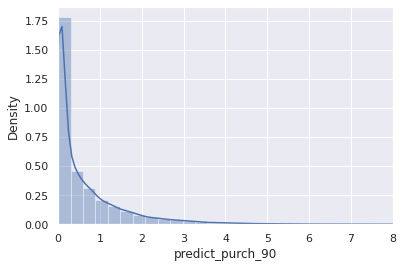

In [ ]:
print("predicted average number of customer purchases over next 90 days:")
ax = sns.distplot(df_rft["predict_purch_90"]).set_xlim(0,8)

In [ ]:
# helper function: probability of n repeat purchases within t days
def prob_purch(t, n):
    p = bgf.probability_of_n_purchases_up_to_time(t, n)
    return p

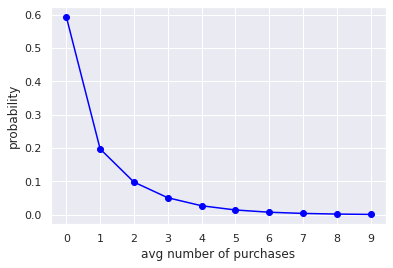

In [ ]:
# call helper function: probability of n repeat purchases within t days
t = 90                  # forecast period, days
purch = range(0,10,1)   # number of repeat purchases 
probs = [prob_purch(t,n) for n in purch]

dict_probs = dict(zip(purch, probs))
#_ = [print(k,":",f'{v:.2f}') for k,v in dict_probs.items()]

plt.plot(purch, probs, '-o', color='blue')
plt.xlabel("avg number of purchases")
plt.ylabel("probability")
plt.xticks(purch)
plt.show()

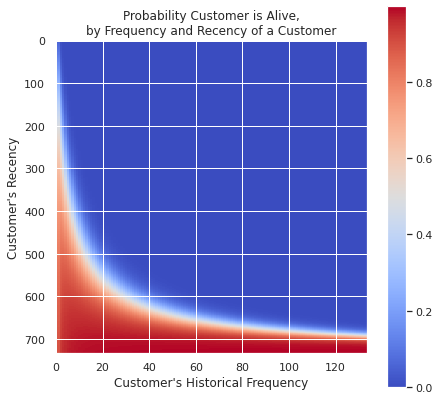

In [ ]:
# probability that a customer has not churned (= is alive), based on 
# customer's specific recency r and frequency f
fig = plt.figure(figsize=(7, 7)) 
plot_probability_alive_matrix(
            model = bgf,  
            max_frequency = max_freq,  
            max_recency = max_rec);

In [ ]:
# probability that a customer is alive for each customer in dataframe
prob_alive = bgf.conditional_probability_alive(
        frequency = df_rft["frequency"], 
        recency = df_rft["recency"], 
        T = df_rft["T"])

df_rft["prob_alive"] = prob_alive
pd.options.display.float_format = '{:,.2f}'.format
df_rft.describe()

frequency   recency  ...  predict_purch_90  prob_alive
count  77,724.00 77,724.00  ...         77,724.00   77,724.00
mean        4.41    223.96  ...              0.64        0.54
std         7.66    259.12  ...              0.93        0.34
min         0.00      0.00  ...              0.00        0.00
25%         0.00      0.00  ...              0.05        0.21
50%         1.00     69.00  ...              0.25        0.49
75%         6.00    471.00  ...              0.86        0.91
max       133.00    732.00  ...             14.87        1.00

[8 rows x 13 columns]

In [ ]:
# show customers who are alive, but with less than 90% certainty
df_rft[df_rft["prob_alive"] < 0.9]

frequency  recency  ...  predict_purch_90  prob_alive
CustomerID                         ...                              
9100000000091       0.00     0.00  ...              0.02        0.15
9100000000152       0.00     0.00  ...              0.02        0.14
9100000000220       2.00   455.00  ...              0.37        0.89
9100000000237       2.00   271.00  ...              0.19        0.53
9100000000244      56.00   655.00  ...              4.63        0.72
...                  ...      ...  ...               ...         ...
9100003125562       0.00     0.00  ...              0.19        0.41
9100003140534       1.00   399.00  ...              0.18        0.75
9100003149889       1.00    12.00  ...              0.20        0.35
9100003151981       0.00     0.00  ...              0.06        0.24
9100003206438       0.00     0.00  ...              0.03        0.18

[56948 rows x 13 columns]

In [ ]:
# pick a customer
custID = 9100000000114
df_rft[df_rft.index == custID]

frequency  recency  ...  predict_purch_90  prob_alive
CustomerID                         ...                              
9100000000114       7.00   540.00  ...              0.94        0.94

[1 rows x 13 columns]

In [ ]:
# select a customer
df1C = df1[df1["CustomerID"] == custID]
df1C.describe()

Quantity  UnitPrice           CustomerID  Revenue
count     19.00      19.00                19.00    19.00
mean       1.26   1,430.16 9,100,000,000,114.00 2,067.95
std        0.45     885.07                 0.00 1,986.90
min        1.00     155.00 9,100,000,000,114.00   155.00
25%        1.00     851.00 9,100,000,000,114.00   851.00
50%        1.00   1,100.00 9,100,000,000,114.00 1,100.00
75%        1.50   1,767.50 9,100,000,000,114.00 2,570.00
max        2.00   3,588.00 9,100,000,000,114.00 7,176.00

customer 9100000000114 : probability of being alive over time


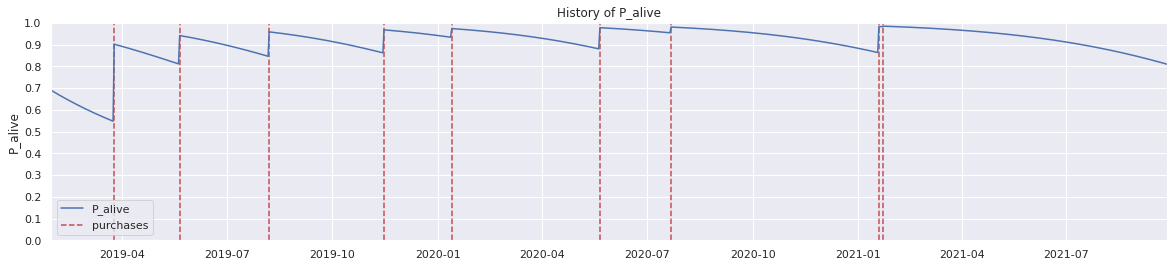

In [ ]:
# history of the selected customer: probability over time of being alive
fig = plt.figure(figsize=(20,4))
print("customer",custID,": probability of being alive over time")
plot_history_alive(
                    model = bgf, 
                    t = span_days, 
                    transactions = df1C, 
                    datetime_col = "InvoiceDate");

In [ ]:
# selected customer's probability of being alive - development over time
path_alive = calculate_alive_path(
            model = bgf, 
            t = span_days, 
            transactions = df1C, 
            datetime_col = "InvoiceDate");
print("customer",custID,"'s probability of being alive, development over time")
path_alive.explode().astype(np.float64).describe()

customer 9100000000114 's probability of being alive, development over time


count   973.00
mean      0.91
std       0.08
min       0.55
25%       0.89
50%       0.93
75%       0.96
max       0.98
dtype: float64

# 4 Customer Lifetime Value: The Gamma-Gamma Model


## 4.1 Fitting the Gamma-Gamma Model


In [ ]:
# select customers with monetary value > 0
df_rftv = df_rft[df_rft["monetary_value"] > 0]
pd.options.display.float_format = '{:,.2f}'.format
df_rftv.describe()

frequency   recency  ...  predict_purch_90  prob_alive
count  44,518.00 44,518.00  ...         44,518.00   44,518.00
mean        7.67    389.13  ...              1.04        0.75
std         8.80    229.56  ...              1.06        0.29
min         1.00      1.00  ...              0.00        0.00
25%         2.00    183.00  ...              0.31        0.62
50%         5.00    420.00  ...              0.72        0.89
75%        10.00    595.00  ...              1.41        0.96
max       133.00    732.00  ...             14.87        1.00

[8 rows x 13 columns]

In [ ]:
# Gamma-Gamma model requires a Pearson correlation close to 0 
# between purchase frequency and monetary value

corr_matrix = df_rftv[["monetary_value", "frequency"]].corr()
corr = corr_matrix.iloc[1,0]
print("Pearson correlation: %.3f" % corr)

Pearson correlation: 0.140


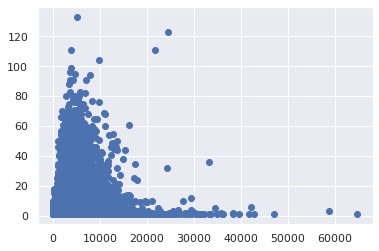

In [ ]:
dfx = df_rftv["monetary_value"]
dfy = df_rftv["frequency"]
plt.scatter(dfx, dfy)

In [ ]:

# outlier
df_rftv[df_rftv["monetary_value"] == df_rftv["monetary_value"].max()]

frequency  recency  ...  predict_purch_90  prob_alive
CustomerID                         ...                              
9100000187525       1.00   420.00  ...              0.24        0.84

[1 rows x 13 columns]

In [ ]:
# fitting the Gamma-Gamma model
# coef: 1.0000000000000002e-07 MAPE of predicted revenues: 0.09 有有unit
# coef: 1.0000000000000002e-06 MAPE of predicted revenues: 0.05 沒有的
ggf = GammaGammaFitter(penalizer_coef = 1e-07)
ggf.fit(
        frequency = df_rftv["frequency"],
        monetary_value = df_rftv["monetary_value"],  
        weights = None,   
        verbose = True,  
        tol = 1e-06,  
        q_constraint = True)
pd.options.display.float_format = '{:,.3f}'.format
ggf.summary

coef  se(coef)  lower 95% bound  upper 95% bound
p   4.542     0.046            4.452            4.633
q   1.574     0.010            1.554            1.595
v 663.259     7.618          648.328          678.191

## 4.2 Predictions

In [ ]:
# estimate the average transaction value of each customer, based on frequency and monetary value
exp_avg_rev = ggf.conditional_expected_average_profit(
        df_rftv["frequency"],
        df_rftv["monetary_value"])

df_rftv["exp_avg_rev"] = exp_avg_rev
df_rftv["avg_rev"] = df_rftv["monetary_value"]
df_rftv["error_rev"] = df_rftv["exp_avg_rev"] - df_rftv["avg_rev"]


mape = mean_absolute_percentage_error(exp_avg_rev, df_rftv["monetary_value"])
print("MAPE of predicted revenues:", f'{mape:.2f}')

pd.options.display.float_format = '{:,.3f}'.format
df_rftv.head()

MAPE of predicted revenues: 0.09


frequency  recency       T  ...  exp_avg_rev   avg_rev  error_rev
CustomerID                                 ...                                  
9100000000060      6.000  527.000 642.000  ...    3,139.072 3,094.667     44.405
9100000000084      6.000  641.000 712.000  ...    6,281.529 6,303.333    -21.804
9100000000114      7.000  540.000 643.000  ...    3,694.039 3,666.000     28.039
9100000000213      3.000  336.000 336.000  ...      975.641   795.667    179.974
9100000000220      2.000  455.000 590.000  ...    1,686.998 1,462.000    224.998

[5 rows x 16 columns]

In [ ]:
# compute customer lifetime value
DISCOUNT_a = 0.06                # annual discount rate
LIFE = 12                        # lifetime expected for the customers in months

discount_m = (1 + DISCOUNT_a)**(1/12) - 1     # monthly discount rate

clv = ggf.customer_lifetime_value(
        transaction_prediction_model = bgf,  
        frequency = df_rftv["frequency"],  
        recency = df_rftv["recency"],  
        T = df_rftv["T"],  
        monetary_value = df_rftv["monetary_value"],  
        time = LIFE,    
        freq = "D",                          
        discount_rate = discount_m)

df_rftv.insert(0, "CLV", clv)             # expected customer lifetime values
df_rftv.describe().T

count       mean  ...        75%           max
CLV                    44,518.000 15,192.216  ... 19,375.258 1,312,983.717
frequency              44,518.000      7.675  ...     10.000       133.000
recency                44,518.000    389.128  ...    595.000       732.000
T                      44,518.000    554.952  ...    698.000       732.000
monetary_value         44,518.000  3,451.600  ...  4,556.587    64,850.000
frequency_holdout      44,518.000      2.249  ...      3.000        73.000
monetary_value_holdout 44,518.000    858.757  ...  1,520.000     7,664.000
duration_holdout       44,518.000    240.000  ...    240.000       240.000
weights                44,518.000      0.615  ...      0.900         0.900
predict_purch_10       44,518.000      0.117  ...      0.159         1.664
predict_purch_30       44,518.000      0.349  ...      0.475         4.982
predict_purch_60       44,518.000      0.695  ...      0.945         9.938
predict_purch_90       44,518.000      1.038  ...      1.412        14.869
prob_alive             44,518.000      0.750  ...      0.964         0.998
exp_avg_rev            44,518.000  3,539.811  ...  4,575.073    58,160.813
avg_rev                44,518.000  3,451.600  ...  4,556.587    64,850.000
error_rev              44,518.000     88.211  ...    144.399       588.711

[17 rows x 8 columns]

In [ ]:
df_rftv.sort_values(by="CLV", ascending=False)


CLV  frequency  ...    avg_rev  error_rev
CustomerID                              ...                      
9100000300535 1,312,983.717    123.000  ... 24,601.276    -19.872
9100000063171 1,034,118.538    111.000  ... 21,835.766    -18.872
9100000473956   523,656.545     36.000  ... 33,212.167    -97.859
9100001584002   440,774.705     61.000  ... 16,240.574    -22.737
9100001543061   432,588.511    104.000  ...  9,788.519     -5.514
...                     ...        ...  ...        ...        ...
9100002589099         0.219      9.000  ...    947.556     59.549
9100002573425         0.204      6.000  ...    824.667     91.246
9100002598343         0.141      6.000  ...    999.667     87.635
9100001139561         0.097      9.000  ...  1,824.222     47.406
9100002572831         0.067     16.000  ...  2,877.500     18.572

[44518 rows x 17 columns]

## 4.3 CLV Clustering

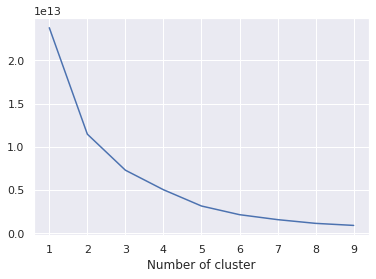

In [ ]:
from sklearn.cluster import KMeans

sse={}
tx_recency = df_rftv[['CLV']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

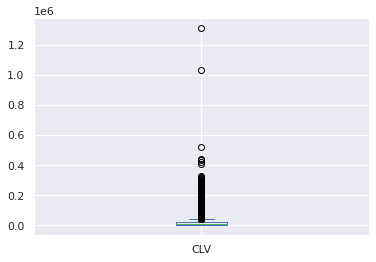

In [ ]:
df_rftv['CLV'].plot.box()

In [ ]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [ ]:
# 我把學姊刪除異常值得部分拿掉，因為前面有處理過了，這裡再放好像怪怪的
#lowerbound,highbound = Outlier_treatment(df_rftv['CLV'])

#df_rft.drop(df_rft[(df_rft['monetary_value'] < lowerbound) | (df_rft['monetary_value']>highbound)],inplace=True)
# df_rftv = df_rftv[(df_rftv['CLV'] < highbound)]

# df_rftv['CLV'].plot.box()

kmeans = KMeans(n_clusters=3)
kmeans.fit(df_rftv[['CLV']])
df_rftv['CLVCluster'] = kmeans.predict(df_rftv[['CLV']])

df_rftv = order_cluster('CLVCluster', 'CLV',df_rftv,True)

df_rftv.groupby('CLVCluster')['CLV'].describe()

count        mean  ...         75%           max
CLVCluster                         ...                          
0          35,123.000   6,976.408  ...  11,206.203    22,357.277
1           8,386.000  37,713.762  ...  45,390.222    75,773.239
2           1,009.000 114,001.080  ... 121,388.095 1,312,983.717

[3 rows x 8 columns]

In [ ]:
di = {0:'Low', 1:'Mid', 2:'High'}
df_rftv['Segment'] = df_rftv['CLVCluster'].map(di)

In [ ]:
df_rftv.columns

Index(['CLV', 'frequency', 'recency', 'T', 'monetary_value',
       'frequency_holdout', 'monetary_value_holdout', 'duration_holdout',
       'weights', 'predict_purch_10', 'predict_purch_30', 'predict_purch_60',
       'predict_purch_90', 'prob_alive', 'exp_avg_rev', 'avg_rev', 'error_rev',
       'CLVCluster', 'Segment'],
      dtype='object')

In [ ]:
import plotly.express as px
df = df_rftv
fig = px.scatter_3d(df, x='prob_alive', y='exp_avg_rev', z='predict_purch_90',
              color='Segment')
fig.show()


## 4.4 Correlation

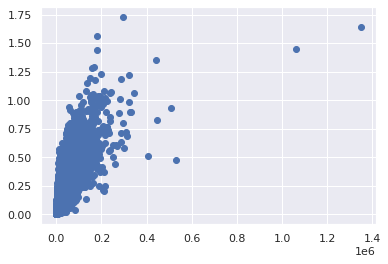

In [ ]:
dfx = df_rftv["CLV"]
dfy = df_rftv["predict_purch_10"]
plt.scatter(dfx, dfy)

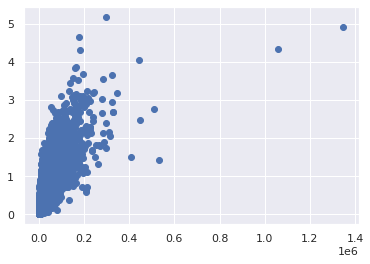

In [ ]:
dfx = df_rftv["CLV"]
dfy = df_rftv["predict_purch_30"]
plt.scatter(dfx, dfy)

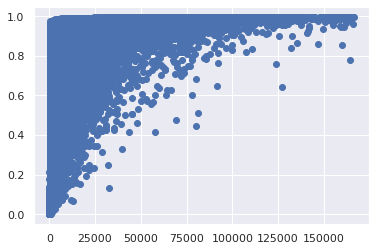

In [ ]:
df = df_rftv.sort_values(by=["CLV"])
dfx = df["CLV"][:-100]
dfy = df["prob_alive"][:-100]
plt.scatter(dfx, dfy)

# 5 Parameter Distributions

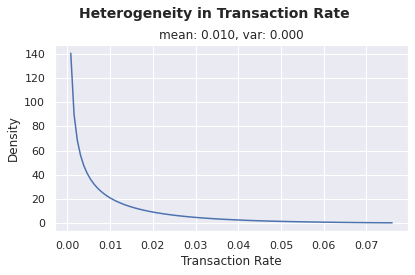

In [ ]:
# Gamma distribution of lambda: customers' propensitiy to purchase
plot_transaction_rate_heterogeneity(model = bgf)   

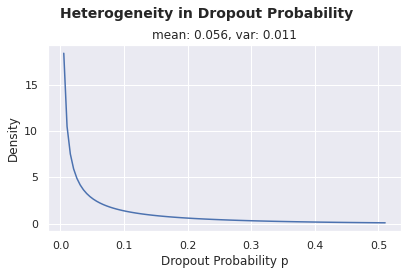

In [ ]:
# Beta distribution of p: customer's probability of dropping out immediately after a transaction
plot_dropout_rate_heterogeneity(model = bgf)

# 6 RFM Clustering

## Kmeans

In [ ]:
df_rft1 = df_rft.copy()
df_rft1['R'] = df_rft1['T']-df_rft1['recency']

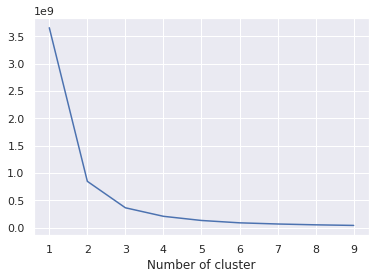

In [ ]:
sse={}
tx_recency = df_rft1[['R']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_rft1[['R']])
df_rft1['RecencyCluster'] = kmeans.predict(df_rft1[['R']])

df_rft1 = order_cluster('RecencyCluster', 'R',df_rft1,False)

df_rft1.groupby('RecencyCluster')['R'].describe()

count    mean    std  ...     50%     75%     max
RecencyCluster                            ...                        
0              17,852.000 588.096 80.036  ... 583.000 658.000 732.000
1              22,126.000 320.354 72.097  ... 319.000 372.000 453.000
2              37,746.000  74.878 59.106  ...  64.000 127.000 197.000

[3 rows x 8 columns]

In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_rft1[['frequency']])
df_rft1['FrequencyCluster'] = kmeans.predict(df_rft1[['frequency']])

#order the frequency cluster
df_rft1 = order_cluster('FrequencyCluster', 'frequency',df_rft1,True)

#see details of each cluster
df_rft1.groupby('FrequencyCluster')['frequency'].describe()

count   mean    std    min    25%    50%    75%     max
FrequencyCluster                                                             
0                60,610.000  1.275  1.781  0.000  0.000  0.000  2.000   6.000
1                14,193.000 11.916  4.218  7.000  8.000 11.000 15.000  22.000
2                 2,921.000 32.863 11.113 23.000 25.000 29.000 36.000 133.000

In [ ]:
# drop outlier
lowerbound,highbound = Outlier_treatment(df_rft1['monetary_value'])

#df_rft.drop(df_rft[(df_rft['monetary_value'] < lowerbound) | (df_rft['monetary_value']>highbound)],inplace=True)
df_rft1 = df_rft1[(df_rft1['monetary_value'] < highbound)]

#apply clustering
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_rft1[['monetary_value']])
df_rft1['RevenueCluster'] = kmeans.predict(df_rft1[['monetary_value']])


#order the cluster numbers
df_rft1 = order_cluster('RevenueCluster', 'monetary_value',df_rft1,True)
#show details of the dataframe
df_rft1.groupby('RevenueCluster')['monetary_value'].describe()

count      mean       std  ...       50%       75%       max
RevenueCluster                                 ...                              
0              44,257.000   211.548   414.277  ...     0.000     0.000 1,529.000
1              20,573.000 2,840.742   754.158  ... 2,822.182 3,470.000 4,238.333
2              10,596.000 5,624.399 1,049.140  ... 5,383.896 6,354.802 8,206.000

[3 rows x 8 columns]

In [ ]:
df_rft1['OverallScore'] = df_rft1['RecencyCluster'] + df_rft1['FrequencyCluster'] + df_rft1['RevenueCluster']


print(df_rft1.groupby('OverallScore')['R'].mean())
print(df_rft1.groupby('OverallScore')['frequency'].mean())
print(df_rft1.groupby('OverallScore')['monetary_value'].mean())

OverallScore
0   592.355
1   344.191
2   157.200
3   138.110
4    71.848
5    49.492
6    26.898
Name: R, dtype: float64
OverallScore
0    0.205
1    0.567
2    1.556
3    4.645
4    9.812
5   18.157
6   33.713
Name: frequency, dtype: float64
OverallScore
0      90.885
1     341.610
2   1,025.218
3   3,147.413
4   3,769.334
5   4,799.410
6   5,533.118
Name: monetary_value, dtype: float64


In [ ]:
df_rft1['Segment'] = 'Low-Value'
df_rft1.loc[df_rft1['OverallScore']>4,'Segment'] = 'Mid-Value' 
df_rft1.loc[df_rft1['OverallScore']>5,'Segment'] = 'High-Value' 
df_rft1

frequency  recency       T  ...    Segment  Segment_  RevenueCluster
0          6.000  527.000 642.000  ...  Low-Value         2               1
1          6.000  590.000 632.000  ...  Low-Value         2               1
2          4.000  409.000 598.000  ...  Low-Value         2               1
3          6.000  564.000 577.000  ...  Low-Value         2               1
4          4.000  723.000 723.000  ...  Low-Value         2               1
...          ...      ...     ...  ...        ...       ...             ...
75421     27.000  466.000 474.000  ...  Low-Value         2               0
75422     25.000  463.000 466.000  ...  Low-Value         2               0
75423     23.000  450.000 452.000  ...  Low-Value         2               0
75424     23.000  333.000 360.000  ...  Low-Value         2               0
75425     25.000  475.000 731.000  ...  Low-Value         2               0

[75426 rows x 19 columns]

## Plot

In [ ]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
df_rft1['Segment_'] = labelencoder.fit_transform(df_rft1['Segment'])


In [ ]:
df = df_rft1
fig = px.scatter_3d(df, x='frequency', y='R', z='monetary_value',
              color='Segment')
fig.show()


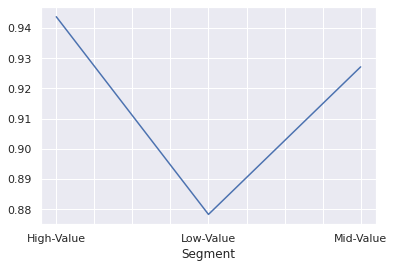

In [ ]:
df_rft1_ = df_rft1.groupby(['Segment'])['prob_alive'].mean()
df_rft1_.plot()
plt.show()